In [1]:
import os

import numpy as np
import torch
import librosa
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from scipy.spatial.distance import cosine, euclidean
import os
from pathlib import Path
import pandas as pd

from tqdm.notebook import tqdm

# to play audio
from IPython.display import Audio

# play spectrogram
import matplotlib.pyplot as plt

In [18]:
# read .env file
from dotenv import load_dotenv
load_dotenv()

# get the token from the .env file
token = os.getenv('HF_TOKEN') or "hf_xxx"

In [3]:
model_name = "facebook/mms-300m"

device = "cuda" if torch.cuda.is_available() else "cpu"

# this should be a path to the Hugging Face cache directory
hf_cache_dir = Path('/home/badr/.cache/huggingface/hub/')

processor = Wav2Vec2FeatureExtractor.from_pretrained(
    model_name, 
    token=token, 
    cache_dir=hf_cache_dir
)
model = Wav2Vec2Model.from_pretrained(
    model_name, 
    token=token, 
    cache_dir=hf_cache_dir
)

model.to(device)
model.eval()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/mms-300m and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout)

In [4]:
def get_audio_waveform(audio_path, sr=16000):
    waveform, orig_sr = librosa.load(audio_path, sr=None)
    if orig_sr != sr:
        waveform = librosa.resample(waveform, orig_sr=orig_sr, target_sr=sr)    
    
    return waveform

In [12]:
def extract_features(audio_path, layer=10, sr=16000):
    """
    extract frame-level features from audio file
    
    Args:
        audio_path: path to audio file
        sr: sampling rate (MMS expects 16kHz)
        
    Returns:
        features: (n_frames, hidden_dim) tensor
    """
    # load and resample audio if needed
    waveform = get_audio_waveform(audio_path, sr=sr)
    
    # process audio through model
    inputs = processor(waveform, sampling_rate=sr, return_tensors="pt")

    #print("inputs", type(inputs))
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

        #print("outputs", dir(outputs))

        # extract features from specified layer
        hidden_states = outputs.hidden_states[layer]

        #print("hidden_states", type(hidden_states)) 

        #print("hidden_states.shape", hidden_states.shape)
        # remove batch dimension and move to cpu
        features = hidden_states.squeeze(0).cpu().numpy()
    
    return features

In [8]:
audio_path = '../audio_files/PL-university.wav'

In [9]:
waveform = get_audio_waveform(audio_path)

In [10]:
# play 
Audio(waveform, rate=16000)

In [14]:
emb_segment = extract_features(audio_path)
emb_segment.shape

(74, 1024)

In [16]:
# get the average of the feature representation
emb_mean = emb_segment.mean(axis=0)
emb_mean.shape

(1024,)

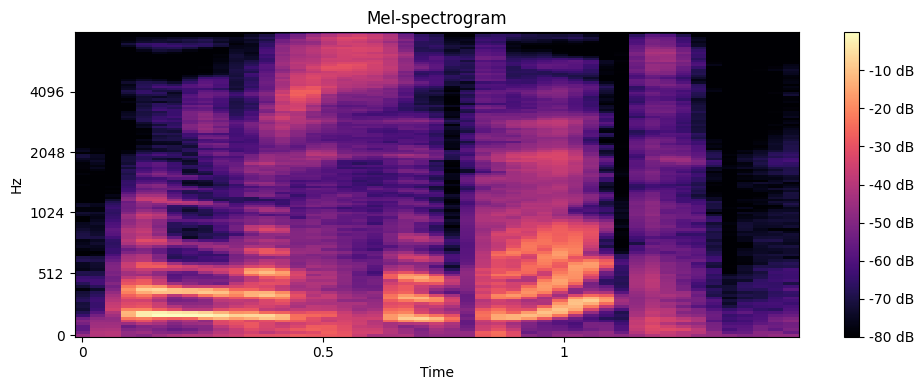

In [17]:
# show spectrogram
plt.figure(figsize=(10, 4))

# convert waveform to mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=16000, n_mels=128, fmax=8000)
# convert to log mel spectrogram
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
# plot log mel spectrogram
librosa.display.specshow(log_mel_spectrogram, sr=16000, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram')
plt.tight_layout()
plt.show()

In [20]:
# extract features from all layers 

layer_to_emb = {}

for layer in tqdm(range(25)):
    emb_segment = extract_features(audio_path, layer=layer)
    emb_mean = emb_segment.mean(axis=0)
    layer_to_emb[layer] = emb_mean


  0%|          | 0/25 [00:00<?, ?it/s]

In [28]:
# plot self-similarity matrix 
import seaborn as sns

num_layers = len(layer_to_emb)
self_sim_mat = np.zeros((num_layers, num_layers))

# Compute cosine similarity between all pairs of layers
# Note: embeddings in layer_to_emb are already mean-pooled
for i in tqdm(range(num_layers)):
    for j in range(i, num_layers):
        # Compute cosine distance and convert to similarity
        dist = cosine(layer_to_emb[i], layer_to_emb[j])
        sim = 1 - dist  # Convert distance to similarity
        self_sim_mat[i, j] = sim
        self_sim_mat[j, i] = sim  # Matrix is symmetric

  0%|          | 0/25 [00:00<?, ?it/s]

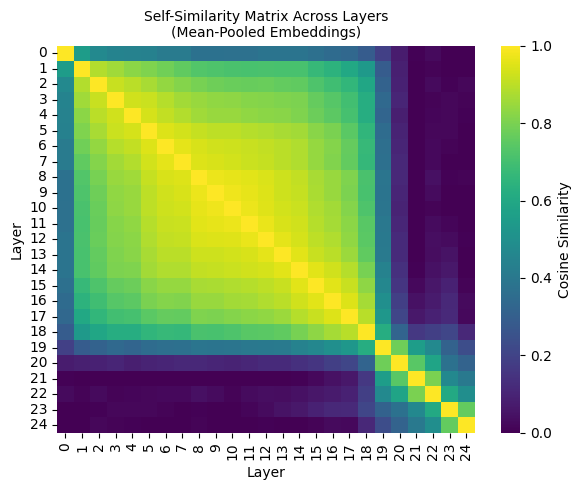

In [38]:
# Plot the self-similarity matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(self_sim_mat, 
            #annot=True, 
            fmt='.3f', 
            cmap='viridis',
            vmin=0, 
            vmax=1,
            xticklabels=range(num_layers),
            yticklabels=range(num_layers),
            cbar_kws={'label': 'Cosine Similarity'})
plt.xlabel('Layer', fontsize=10)
plt.ylabel('Layer', fontsize=10)
plt.title('Self-Similarity Matrix Across Layers\n(Mean-Pooled Embeddings)', fontsize=10)
plt.tight_layout()
plt.show()

In [39]:
# # plot self-similarity matrix 
# plt.figure(figsize=(10, 10))

# # plot the matrix
# plt.imshow(self_sim_mat, cmap='viridis')
# plt.colorbar(label='Cosine Distance')
# plt.title('Self-Similarity Matrix of Audio Embeddings')